El objetivo es crear un sistema de ayuda a la toma de decisión que permita al entrenador(a)
diseñar un plan de partido. El elemento central será un modelo para predecir victorias
basándose en datos del boxscore. Hay un dataset disponible en la plataforma disponible en
el zip llamado plantilla código explicabilidad S-20. Sin embargo, se pueden usar otros
dataset si lo crees conveniente.

- possession = FGA + .475 * FTA - ORB + TOV
- Effective Field Goal Percentage (eFG%) = (FG + .5 * 3P) / FGA
- True Shooting Percentage (TS%) = Pts / (2 * (FGA + .475 * FTA))
- Turnover Percentage (TOV%) = TOV / (FGA + .475*FTA + AST + TOV)
- Offensive Rating (OR -> PointsPerPossesion) = Pts / (Own_Poss + Opp_Poss) * 100
- Defensive Rating (DR -> PointsPerPossesion in defense) = OppPts / (Own_Poss + Opp_Poss) * 100

REGULAR_SEASON_DURATION = {
- 2021: ('2021-10-19', '2022-04-10'),
- 2020: ('2020-12-22', '2021-05-16'),
- 2018: ('2018-10-16', '2019-04-10'),
- 2017: ('2017-10-17', '2018-04-11'),
- 2016: ('2016-10-25', '2017-04-12'),
- 2015: ('2015-10-27', '2016-04-13'),
- 2014: ('2014-10-28', '2015-04-15'),
- 2013: ('2013-10-29', '2014-04-16'),
- 2012: ('2012-10-30', '2013-04-17'),
}



In [1]:
import pandas as pd
datosJugadores = pd.read_csv('data_advanced.csv')[:5000]
datosJugadores.columns

Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away'],
      dtype='object')

In [2]:
# En este código iremos importando las librerias necesarias
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Scipy: Librería con implementación de algoritmos para python de código abierto.
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.stats import pearsonr
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#Seaborn: Librería de visualización.
import seaborn as sns
#Warnings: Supresión de información de warnings por pantalla (prescindible, se utiliza para evitar una salida muy extensa).
import warnings
warnings.filterwarnings('ignore')


Preguntas
## 1. Explora los datos. Descríbelos brevemente (qué columnas, cuántas filas, etc.).


Hacemos una visualizacion de los datos para ver que columnas tenemos 

In [3]:
datosJugadores.head(n=10)

,Unnamed: 0,GAME_DATE_EST,AST_home,BLK_home,DREB_home,FG3A_home,FG3M_home,FGA_home,FGM_home,FTA_home,...,EFG%_home,EFG%_away,TS%_home,TS%_away,TOV%_home,TOV%_away,OR_home,OR_away,DR_home,DR_away
0,0,2022-04-10,30.0,6.0,42.0,22.0,8.0,81.0,52.0,25.0,...,0.575000,0.482143,0.610932,0.499030,0.087977,0.126000,60.808108,48.006401,48.006401,60.808108
1,1,2022-04-10,34.0,9.0,37.0,33.0,18.0,89.0,48.0,14.0,...,0.530864,0.480769,0.560239,0.531116,0.200131,0.197935,49.018441,47.114813,47.114813,49.018441
2,2,2022-04-10,39.0,5.0,38.0,38.0,19.0,94.0,51.0,17.0,...,0.478022,0.422222,0.496957,0.469029,0.108499,0.109017,51.667326,48.504020,48.504020,51.667326
3,3,2022-04-10,24.0,4.0,28.0,46.0,17.0,89.0,41.0,20.0,...,0.561644,0.537500,0.601719,0.553360,0.146699,0.119344,54.744526,51.094891,51.094891,54.744526
4,4,2022-04-10,27.0,6.0,26.0,47.0,15.0,102.0,39.0,27.0,...,0.615385,0.532468,0.603275,0.523207,0.112216,0.127607,56.481980,50.026896,50.026896,56.481980
5,5,2022-04-10,32.0,5.0,38.0,43.0,15.0,87.0,40.0,12.0,...,0.487500,0.552941,0.511716,0.572831,0.147025,0.148630,49.101951,54.270578,54.270578,49.101951
6,6,2022-04-10,33.0,3.0,42.0,58.0,23.0,91.0,45.0,14.0,...,0.519231,0.464706,0.545820,0.494225,0.147023,0.079149,51.602390,49.972841,49.972841,51.602390
7,7,2022-04-10,25.0,6.0,32.0,25.0,5.0,88.0,46.0,23.0,...,0.428571,0.339744,0.459893,0.387382,0.105263,0.117245,50.336553,40.971613,40.971613,50.336553
8,8,2022-04-10,30.0,9.0,23.0,31.0,11.0,91.0,46.0,22.0,...,0.548780,0.392857,0.567498,0.447071,0.111988,0.163371,54.239145,47.664703,47.664703,54.239145
9,9,2022-04-10,34.0,3.0,33.0,36.0,20.0,85.0,46.0,23.0,...,0.462025,0.527473,0.531023,0.547667,0.159699,0.108499,46.330163,52.670080,52.670080,46.330163


Vemos que el data.frame que hemos seleccionado es de 5000 filas y 43 columnas

In [4]:
datosJugadores.shape

(5000, 43)

Todos nuestros datos tienen el formato **float** excepto HOME_TEAM_WINS y GAME_DATE_EST

In [5]:
datosJugadores.dtypes

Unnamed: 0           int64
GAME_DATE_EST       object
AST_home           float64
BLK_home           float64
DREB_home          float64
FG3A_home          float64
FG3M_home          float64
FGA_home           float64
FGM_home           float64
FTA_home           float64
FTM_home           float64
OREB_home          float64
PF_home            float64
STL_home           float64
TO_home            float64
AST_away           float64
BLK_away           float64
DREB_away          float64
FG3A_away          float64
FG3M_away          float64
FGA_away           float64
FGM_away           float64
FTA_away           float64
FTM_away           float64
OREB_away          float64
PF_away            float64
STL_away           float64
TO_away            float64
HOME_TEAM_WINS       int64
Points_home        float64
Points_away        float64
Possesions_home    float64
Possesions_away    float64
EFG%_home          float64
EFG%_away          float64
TS%_home           float64
TS%_away           float64
T

Hacemos una estadística descriptiva básica de nuestros parametros. Ya poddemos ver que las escalas de todos ellos son diferentes, tambien vemos que hay que revisar si nos encontramos con valores extremos en nuestros datos.

In [6]:
datosJugadores.describe().T
#datosJugadores.describe(include='object')



,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5000.0,580.398200,355.283575,0.000000,262.000000,574.000000,887.000000,1229.000000
AST_home,5000.0,25.128800,6.605463,10.000000,21.000000,25.000000,28.000000,104.000000
BLK_home,5000.0,5.048600,2.690592,0.000000,3.000000,5.000000,7.000000,24.000000
DREB_home,5000.0,35.304400,8.014823,16.000000,31.000000,35.000000,38.000000,132.000000
FG3A_home,5000.0,33.251800,9.579726,9.000000,27.000000,32.000000,38.000000,126.000000
FG3M_home,5000.0,11.962800,4.338200,1.000000,9.000000,12.000000,14.000000,46.000000
FGA_home,5000.0,89.429400,16.050687,64.000000,83.000000,88.000000,93.000000,278.000000
FGM_home,5000.0,41.588000,8.075475,22.000000,37.000000,41.000000,45.000000,138.000000
FTA_home,5000.0,22.843600,8.429196,1.000000,17.000000,22.000000,27.000000,100.000000
FTM_home,5000.0,17.608000,6.751819,1.000000,13.000000,17.000000,21.000000,88.000000


No tenemos valores perdidos.

In [7]:
#Número total de nulos
datosJugadores.isnull().sum().sum()

0

In [8]:
datosJugadores.isnull().sum()

Unnamed: 0         0
GAME_DATE_EST      0
AST_home           0
BLK_home           0
DREB_home          0
FG3A_home          0
FG3M_home          0
FGA_home           0
FGM_home           0
FTA_home           0
FTM_home           0
OREB_home          0
PF_home            0
STL_home           0
TO_home            0
AST_away           0
BLK_away           0
DREB_away          0
FG3A_away          0
FG3M_away          0
FGA_away           0
FGM_away           0
FTA_away           0
FTM_away           0
OREB_away          0
PF_away            0
STL_away           0
TO_away            0
HOME_TEAM_WINS     0
Points_home        0
Points_away        0
Possesions_home    0
Possesions_away    0
EFG%_home          0
EFG%_away          0
TS%_home           0
TS%_away           0
TOV%_home          0
TOV%_away          0
OR_home            0
OR_away            0
DR_home            0
DR_away            0
dtype: int64

En la etapa de preprocesado detectaremos anomalias en nuestros datos. Sobre el conjunto de variables de interes estudiamos el metodo Isolation Forest. Este método es un algoritmo de detección de anomalías que se utiliza para identificar observaciones inusuales o atípicas en un conjunto de datos. La idea central detrás del método Isolation Forest es que las observaciones anómalas son más fáciles de aislar que las observaciones normales en un espacio de características multidimensionales. El algoritmo se basa en la construcción de un conjunto de árboles de decisión aleatorios, donde cada árbol divide recursivamente el espacio de características en subconjuntos más pequeños.

In [9]:
datosJugadores.columns

Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away'],
      dtype='object')

In [10]:
datosJugadores.filter(regex='(_home|_away)$').columns

Index(['AST_home', 'BLK_home', 'DREB_home', 'FG3A_home', 'FG3M_home',
       'FGA_home', 'FGM_home', 'FTA_home', 'FTM_home', 'OREB_home', 'PF_home',
       'STL_home', 'TO_home', 'AST_away', 'BLK_away', 'DREB_away', 'FG3A_away',
       'FG3M_away', 'FGA_away', 'FGM_away', 'FTA_away', 'FTM_away',
       'OREB_away', 'PF_away', 'STL_away', 'TO_away', 'Points_home',
       'Points_away', 'Possesions_home', 'Possesions_away', 'EFG%_home',
       'EFG%_away', 'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away',
       'OR_home', 'OR_away', 'DR_home', 'DR_away'],
      dtype='object')

In [11]:
variablesUsar = datosJugadores.filter(regex='(_home|_away)$').columns
datosJugadoresParaOutliers = datosJugadores[variablesUsar].copy()

Nos encontramos con 250 observaciones que son consideradas anomalias segun el método mencionado.

In [12]:
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
# Entrenar el modelo con los datos
model.fit(datosJugadoresParaOutliers)
# Predecir las anomalías (observaciones anómalas)
predictions = model.predict(datosJugadoresParaOutliers)
# Agregar las predicciones al DataFrame original
datosJugadoresParaOutliers['Anomaly'] = predictions
datosJugadoresParaOutliers[datosJugadoresParaOutliers['Anomaly']==-1].describe()


,AST_home,BLK_home,DREB_home,FG3A_home,FG3M_home,FGA_home,FGM_home,FTA_home,FTM_home,OREB_home,...,EFG%_away,TS%_home,TS%_away,TOV%_home,TOV%_away,OR_home,OR_away,DR_home,DR_away,Anomaly
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.0
mean,33.560000,7.056000,47.900000,47.400000,16.508000,121.968000,55.028000,31.720000,23.956000,14.448000,...,0.503139,0.531862,0.533337,0.134003,0.135603,51.337462,51.299510,51.299510,51.337462,-1.0
std,17.398195,4.832627,24.136368,24.699967,8.989169,55.883188,24.726033,19.198435,14.676227,8.914098,...,0.098249,0.081222,0.090930,0.041420,0.042025,8.034171,9.092706,9.092706,8.034171,0.0
min,10.000000,0.000000,20.000000,17.000000,3.000000,69.000000,23.000000,7.000000,3.000000,2.000000,...,0.304878,0.369478,0.334294,0.038760,0.039370,34.836353,31.793888,31.793888,34.836353,-1.0
25%,22.000000,4.000000,33.000000,31.000000,10.000000,86.000000,39.000000,18.000000,14.000000,8.000000,...,0.430675,0.472502,0.462923,0.108696,0.106027,45.597180,43.461564,43.461564,45.597180,-1.0
50%,29.000000,6.000000,39.000000,39.500000,15.000000,95.000000,46.000000,26.000000,19.500000,12.000000,...,0.506454,0.528790,0.537142,0.130704,0.130933,51.492539,50.440173,50.440173,51.492539,-1.0
75%,36.000000,8.000000,54.000000,55.750000,20.000000,125.250000,59.500000,39.750000,31.000000,18.000000,...,0.575269,0.598133,0.599440,0.159520,0.166363,57.518509,57.088995,57.088995,57.518509,-1.0
max,104.000000,24.000000,132.000000,126.000000,46.000000,278.000000,138.000000,100.000000,88.000000,50.000000,...,0.691860,0.723099,0.712112,0.256586,0.265152,67.311515,70.066976,70.066976,67.311515,-1.0


Eliminaremos esas observaciones de nuestro data frame

In [13]:
datosJugadores['Anomaly']=datosJugadoresParaOutliers['Anomaly']
datosJugadores = datosJugadores[datosJugadores['Anomaly']==1]
datosJugadores = datosJugadores.drop('Anomaly',axis=1)

Para que la escala de nuestros datos no afecte a los resultados, deberemos de hacer algún tipo de transformación. Se decide aplicar la normalización denominada MinMaxScaler a todas las variables , menos las que se trata de porcentajes. Utilizamos esta normalización con el objetivo que todos nuestros datos queden entre 0 y 1. La manera de hacerlo es la siguiente

1. Identifica el valor mínimo (min) y el valor máximo (max) de cada característica.
2. Escala cada valor de la característica usando la fórmula:


$$ \text{Valor escalado} = \frac{\text{Valor original} - \text{Valor mínimo}}{\text{Valor máximo} - \text{Valor mínimo}} $$


Esto garantiza que todos los valores estén en la misma escala y puedan compararse de manera equitativa. MinMaxScaler es útil cuando las características de los datos están en diferentes escalas, ayudando a evitar que las características con valores más grandes dominen el análisis.

In [14]:
datosJugadores.columns

Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away'],
      dtype='object')

Para entender bien el data frame podriamos hacer la siguiente interpretacion. Si nosotros queremos analizar los datos de nuestro equipo, consideramos que estos son los que pone "home", y los de nuestros rivales los que pone 'away'.  Con el data frame tal cual esta, cada fila sería un partido, y tenemos como posibles outcomes que podriamos analizar
- Ganamos o perdemos un partido. En la misma fila tendriamos los datos nuestros y los de nuestro rival. Modelo de clasificacion.
- Cuantos puntos anotamos en cada partido. Modelo de regresión.

In [15]:
datosJugadores.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,4750.0,581.684632,357.741260,0.000000,256.000000,586.500000,891.000000,1229.000000
AST_home,4750.0,24.685053,5.110669,10.000000,21.000000,24.000000,28.000000,50.000000
BLK_home,4750.0,4.942947,2.484466,0.000000,3.000000,5.000000,6.000000,19.000000
DREB_home,4750.0,34.641474,5.318146,16.000000,31.000000,35.000000,38.000000,54.000000
FG3A_home,4750.0,32.507158,7.315863,9.000000,27.000000,32.000000,37.000000,68.000000
FG3M_home,4750.0,11.723579,3.798573,1.000000,9.000000,11.000000,14.000000,28.000000
FGA_home,4750.0,87.716842,6.983935,64.000000,83.000000,87.000000,92.000000,125.000000
FGM_home,4750.0,40.880632,5.155680,22.000000,37.000000,41.000000,44.000000,63.000000
FTA_home,4750.0,22.376421,7.148442,1.000000,17.000000,22.000000,27.000000,49.000000
FTM_home,4750.0,17.273895,5.870302,1.000000,13.000000,17.000000,21.000000,39.000000


El siguiente codigo lo prepare por si necesitaba tener dos filas para los datos de cada partido pero finalmente la estrategia que utilizo precisa de tener todos los datos del partido en una sola fila

In [16]:
datosJugadores['AWAY_TEAM_WINS'] = datosJugadores['HOME_TEAM_WINS'].apply(lambda x: 0 if x == 1 else 1)

# Crear una columna id_partido para identificar cada partido
datosJugadores['id_partido'] = range(1, len(datosJugadores) + 1)

# Crear listas de columnas para home y away, incluyendo id_partido
home_cols = [col for col in datosJugadores.columns if col.endswith('_home') or col in ['GAME_DATE_EST', 'HOME_TEAM_WINS', 'id_partido']]
away_cols = [col for col in datosJugadores.columns if col.endswith('_away') or col in ['GAME_DATE_EST', 'AWAY_TEAM_WINS', 'id_partido']]

# Renombrar las columnas para hacerlas homogéneas
df_home = datosJugadores[home_cols].rename(columns=lambda x: x.replace('_home', '') if x not in ['GAME_DATE_EST', 'HOME_TEAM_WINS', 'id_partido'] else x)
df_away = datosJugadores[away_cols].rename(columns=lambda x: x.replace('_away', '') if x not in ['GAME_DATE_EST', 'AWAY_TEAM_WINS', 'id_partido'] else x)

# Añadir una columna TEAM_TYPE para identificar si es home o away
df_home['TEAM_TYPE'] = 'home'
df_away['TEAM_TYPE'] = 'away'

# Cambiar el nombre de la columna HOME_TEAM_WINS en df_home a TEAM_WINS
df_home = df_home.rename(columns={'HOME_TEAM_WINS': 'TEAM_WINS'})

# Cambiar el nombre de la columna AWAY_TEAM_WINS en df_away a TEAM_WINS
df_away = df_away.rename(columns={'AWAY_TEAM_WINS': 'TEAM_WINS'})

# Combinar los dos DataFrames
df_combined = pd.concat([df_home, df_away], ignore_index=True)

# Ordenar las columnas para que TEAM_TYPE y TEAM_WINS estén al final
cols = [col for col in df_combined.columns if col not in ['TEAM_TYPE', 'TEAM_WINS']] + ['TEAM_TYPE', 'TEAM_WINS']
df_combined = df_combined[cols]



In [17]:
#df_combined

## 2. Con los datos que tienes, ¿cómo puedes resolver el problema? Describe cómo preprocesarías los datos para ello. Pista: clasificación vs. regresión, feature engineering vs. feature learning, tipo de modelo que vas a usar, qué características (columnas) de los datos de entrada vas a usar y por qué… Comentario: ¡Sé creativo si quieres, no hay por qué utilizar sólo lo que hemos visto en las clases!


Con los datos que tenemos podemos resolver varios tipos de problemas, pero como he comentado anteriormente nos podriamos plantear dos de inicio, uno de clasificación que sería plantear un modelo predictivo con el objeto de predecir si un partido basado en el box-score determina una victoria o una derrota. O tambien podríamos plantear un modelo de regresión que plantee que a partir de los datos de boxscore sea capaz de determinar el número de puntos que nuestro equipo anota en el partido. Ambos enfoques me parecen interesantes, aunque en el planteamiento inicial se indica que tenemos que ayudar al entrenador a diseñar un plan de partido para predecir victorias, si somos capaces de  determinar un modelo que sea capaz de predecir el numero de puntos anotados puede ser de ayuda para poder ser capaz de determinar que elementos del juego puede ser interesantes trabajar antes y durante el partido para lograr un número de puntos que nos lleve a la victoria

Una vez elegido este enfoque vamos a hacer un trabajo de feature engineering es decir vamos a usar nuestro conocimiento para elegir los inputs de entrada de nuestro modelo así como a partir de los datos que tenemos crear otros que nos ayuden. 

- Vamos a calcular el porcentaje de tiros libres respecto a los tiros de campos FTM/FGA*100 que es el cuarto factor de oliver (No es necesario escalarlo porque ya esta entre 0 y 1)
- Porcentaje de acierto del tiro de 3 FG3M/FG3A
- Porcentaje de acierto del tiro de campo FGM/FGA
- Porcentaje de acierto del tiro libre FTM/FTA
- Ratio de asistencias/pérdidas (AST/TO): ratio que computa el número de asistencias que se reparten por cada balón que se pierde. 
- Tasa de Rebotes Ofensivos: Es el porcentaje de rebotes ofensivos que toma un equipo sobre el total de los rebotes disponibles. La suma del porcentaje de rebotes defensivos del rival y el porcentaje de rebotes ofensivos propios debe dar 100%.

In [18]:
datosJugadores['FTM_FGA%_home']=datosJugadores['FTM_home'] / datosJugadores['FGA_home']
datosJugadores['FTM_FGA%_away']=datosJugadores['FTM_away'] / datosJugadores['FGA_away']
datosJugadores['FG3%_home']=datosJugadores['FG3M_home'] / datosJugadores['FG3A_home']
datosJugadores['FG3%_away']=datosJugadores['FG3M_away'] / datosJugadores['FG3A_away']

datosJugadores['FG%_home']=datosJugadores['FGM_home'] / datosJugadores['FGA_home']
datosJugadores['FG%_away']=datosJugadores['FGM_away'] / datosJugadores['FGA_away']

datosJugadores['FT%_home']=datosJugadores['FTM_home'] / datosJugadores['FTA_home']
datosJugadores['FT%_away']=datosJugadores['FTM_away'] / datosJugadores['FTA_away']

datosJugadores['Ratio_AST_TO_home']=datosJugadores['AST_home'] / datosJugadores['TO_home']
datosJugadores['Ratio_AST_TO_away']=datosJugadores['AST_away'] / datosJugadores['TO_away']

datosJugadores['REB_OF%_home']=datosJugadores['OREB_home'] / (datosJugadores['DREB_away']+datosJugadores['OREB_home'])
datosJugadores['REB_OF%_away']=datosJugadores['OREB_away'] / (datosJugadores['DREB_home']+datosJugadores['OREB_away'])


Normalizamos nuestras variables para que todas esten en un rango 0-1

In [19]:
variablesNormalizar = [col for col in datosJugadores.columns if (col.endswith('_home') or col.endswith('_away')) and '%' not in col]
#variablesNormalizar = ['Age','G','GS','MP','ORB', 'DRB','AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
#Definición del objeto de scalado.
#scal_age = MinMaxScaler()
#Aprendizaje sobre los datos
#scal_age.fit(datosJugadores[variablesNormalizar])
#Aplicación sobre la columna e incorporación al dataframe de pandas.
#datosJugadores[variablesNormalizar]=scal_age.transform(datosJugadoresCleanCluster[variablesNormalizar])

# Definir el objeto de MinMaxScaler para la normalización


scalers = {}
for var in variablesNormalizar:
    scaler = MinMaxScaler()
    new_column_name = var + '_scal'
    datosJugadores[new_column_name] = scaler.fit_transform(datosJugadores[[var]])
    scalers[var] = scaler
datosJugadores.columns


Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away', 'AWAY_TEAM_WINS', 'id_partido', 'FTM_FGA%_home',
       'FTM_FGA%_away', 'FG3%_home', 'FG3%_away', 'FG%_home', 'FG%_away',
       'FT%_home', 'FT%_away', 'Ratio_AST_TO_home', 'Ratio_AST_TO_away',
       'REB_OF%_home', 'REB_OF%_away', 'AST_home_scal', 'BLK_home_scal',
       'DREB_home_scal', 'FG3A_home_scal', 'FG3M_home_scal', 'FGA_home_scal',
       'FGM_home_scal', 'FTA_home_sca

Teniendo en cuenta el objetivo de predecir el número de puntos anotados por nuestro equipo, los parametros que vamos a usar como inputs del modelo son los siguientes basado en el conocimiento son los siguientes:

- Porcentaje de tiros de campos propio
- Porcentaje de tiros de 3 propio
- Ratio Tiros libres por tiros de campo propio
- Ratio de Asistencias / Perdidas propio
- EFG% propio
- Offensive Rating
- Tasa de Rebotes Ofensivos Propio


In [20]:
datosJugadores.columns

Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away', 'AWAY_TEAM_WINS', 'id_partido', 'FTM_FGA%_home',
       'FTM_FGA%_away', 'FG3%_home', 'FG3%_away', 'FG%_home', 'FG%_away',
       'FT%_home', 'FT%_away', 'Ratio_AST_TO_home', 'Ratio_AST_TO_away',
       'REB_OF%_home', 'REB_OF%_away', 'AST_home_scal', 'BLK_home_scal',
       'DREB_home_scal', 'FG3A_home_scal', 'FG3M_home_scal', 'FGA_home_scal',
       'FGM_home_scal', 'FTA_home_sca

## 3. Escoge el modelo que vas a usar para resolver el problema y descríbelo. Consejo: utiliza la librería scikit-learn y lee la documentación para entender las opciones (hiperparametros) del modelo.


Ya hemos comentado que vamos a elegir un modelo de regresión. 
De inicio nos podriamos plantear las siguiente cuatro opciones para predecir el número de puntos anotados:
- Regresión Lineal: Implementar Regresión Lineal para predecir puntos de baloncesto.
- Modelo de Vecinos Más Cercanos (KNN): Utilizar un modelo KNN para la predicción de puntos.
- Modelo de Árbol de Decisión: Implementar un Árbol de Decisión para la predicción de puntos.

Como la regresión lineal, la haremos mas adelante y el modelo de árbol de decisión lo utilizamos en la practica anterior, utilizaremos el modelo de los vecinos más cercanos.

Buscamos la información del modelo en https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

De forma muy resumidad, un k-nn en regresión funciona evaluando los datos, identificando las instancias más cercanas y calculando su media. Dado que no es un método paramétrico, resulta especialmente efectivo en modelos de regresión.

Es un modelo arriesgado ya que se suele utilizar mas en clasificación que en regresión. En regresión el knn va a ir mirando y calculando la distancia más cercana y va a hacer una media en función de cuántas instancias escojamos.

Si no tenemos suficientes datos, el sobreajuste no estará bien ajustado y, en general, será una mala idea. Además, con pocos datos, el modelo ni siquiera será utilizable, ya que habrá regiones sin ejemplos, mal ajustadas y muy sensibles al ruido. Por lo tanto, si no eliminamos correctamente los valores atípicos y surge un punto mal ubicado, este impactará significativamente en los vecinos.

La forma de solucionar esto puede ser aumentar el valor de K, pero podria producir problemas de desbordamiento, así que lo que podemos hacer es ponderar la distancia elegida, dando mas peso a los más cercanos y menos a los mas alejados. De hecho este es uno de los parametros de la función  **KNeighborsRegressor**. 
> Weight function used in prediction. Possible values:
> - ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
> - ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
> - callable : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

Otro de los parametros que se pueden tunear es el número **k** de vecinos más cercanos

El tercero parametro que tendremos que analizar es que tipo de distancia utilizamos, en la función **KNeighborsRegressor**, leyendo la documentación nos encontramos con lo siguiente 

> pfloat, predeterminado=2

> Parámetro de potencia para la métrica de Minkowski. Cuando p = 1, esto equivale a usar manhattan_distance (l1), y euclidean_distance (l2) para p = 2. Para un p arbitrario, se utiliza minkowski_distance (l_p).
> metricstr, objeto DistanceMetric o invocable, predeterminado=’minkowski’

> Métrica a usar para el cálculo de distancias. El valor predeterminado es “minkowski”, que resulta en la distancia euclidiana estándar cuando p = 2. Consulta la documentación de scipy.spatial.distance y las métricas > listadas en distance_metrics para valores de métricas válidos.,

> Si la métrica es “precomputed”, se asume que X es una matriz de distancias y debe ser cuadrada durante el ajuste. X puede ser un gráfico disperso, en cuyo caso solo los elementos “no nulos” pueden ser considerados vecinos.

> Si la métrica es una función invocable, toma dos matrices que representan vectores 1D como entradas y debe devolver un valor que indique la distancia entre esos vectores. Esto funciona para las métricas de Scipy, pero es menos eficiente que pasar el nombre de la métrica como una cadena.




Para evaluar si tenemos un modelo o no utilizaremos el estadístico r2_score, que mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. El puntaje $R^2$ calculado cuantifica el rendimiento predictivo del modelo en los datos de prueba.

In [21]:
datosJugadores.columns

Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away', 'AWAY_TEAM_WINS', 'id_partido', 'FTM_FGA%_home',
       'FTM_FGA%_away', 'FG3%_home', 'FG3%_away', 'FG%_home', 'FG%_away',
       'FT%_home', 'FT%_away', 'Ratio_AST_TO_home', 'Ratio_AST_TO_away',
       'REB_OF%_home', 'REB_OF%_away', 'AST_home_scal', 'BLK_home_scal',
       'DREB_home_scal', 'FG3A_home_scal', 'FG3M_home_scal', 'FGA_home_scal',
       'FGM_home_scal', 'FTA_home_sca

Selecciono cuales son las variables del modelo

In [22]:
variablesModelo = ['FG3%_home', 'FG%_home', 'FTM_FGA%_home', 'Ratio_AST_TO_home_scal','EFG%_home', 'OR_home_scal','REB_OF%_home']


## 4. Divide los datos entre train y test. Entrena varias veces el modelo utilizando selecciones diferentes hiperparametros (al menos tres). ¿Cuál funciona mejor? Pista: puedes utilizar un for loop o la función GridSearchCV de Sckit-Learn


In [23]:
'''---------------- Normal training --------------'''
#from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

#Definición de columnas de entrada al algoritmo.
input_columns= variablesModelo
#Definición de columna de salida u objetivo.
target_column='Points_home_scal'


In [24]:
datosJugadores_backup = datosJugadores.copy()
datosJugadoresModelo = datosJugadores[variablesModelo + [target_column]]
datosJugadoresModelo

,FG3%_home,FG%_home,FTM_FGA%_home,Ratio_AST_TO_home_scal,EFG%_home,OR_home_scal,REB_OF%_home,Points_home_scal
1,0.545455,0.539326,0.112360,0.063717,0.530864,0.392513,0.297297,0.486486
2,0.500000,0.542553,0.127660,0.141062,0.478022,0.468571,0.232558,0.418919
3,0.369565,0.460674,0.168539,0.177699,0.561644,0.556928,0.139535,0.513514
4,0.319149,0.382353,0.166667,0.092212,0.615385,0.606816,0.311475,0.513514
5,0.348837,0.459770,0.114943,0.069145,0.487500,0.394911,0.227273,0.378378
...,...,...,...,...,...,...,...,...
4995,0.384615,0.500000,0.219512,0.049178,0.560000,0.479514,0.333333,0.459459
4996,0.269231,0.363636,0.295455,0.051191,0.525316,0.526906,0.226415,0.364865
4997,0.375000,0.426829,0.231707,0.116056,0.440217,0.272916,0.142857,0.297297
4998,0.307692,0.512821,0.256410,0.060809,0.500000,0.497038,0.162791,0.472973


Primero vamos a generar un modelo probando varios tamaños de las particiones para los datos test y de training, así como diferentes valores de la semilla.
Vemos que el mejor modelo es el que tiene un tamaño de los datos de test del 15% y la semilla es 42 con un valor de $R^2$ de 0.70

In [25]:
from sklearn.model_selection import train_test_split , GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

test_sizes = [0.15, 0.2, 0.25, 0.3]
random_states = [0, 1, 42, 43, 100, 313]

best_test_size = None
best_random_state = None
best_r2_score = -float('inf')

for test_size in test_sizes:
    for random_state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(datosJugadoresModelo.drop('Points_home_scal', axis=1), datosJugadoresModelo['Points_home_scal'], test_size=test_size, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        if r2 > best_r2_score:
            best_predictions = y_pred
            best_model = model
            best_r2_score = r2
            best_test_size = test_size
            best_random_state = random_state
            msr = mean_squared_error(y_test,y_pred)

print(f"Best test size: {best_test_size}")
print(f"Best random state: {best_random_state}")
print(f"Best R2 score: {best_r2_score}")
print(f"RMSE for this model: {msr}")

Best test size: 0.15
Best random state: 42
Best R2 score: 0.7051551617824656
RMSE for this model: 0.007214487904378357


Ahora vamos a generar otro modelo pero buscando la mejor parametrizacion posible en lo que refiere al numero de vecinos, a los pesos usados y al parametro de potencia.
Vemos que con esta estrategia, es decir sin usar los parametros por defecto y buscando una buena configuración mejoramos el modelo anterior en explicabilidad y reduciendo el error RMSE

In [26]:
X_train, X_test, y_train, y_test = train_test_split(datosJugadoresModelo.drop('Points_home_scal', axis=1), datosJugadoresModelo['Points_home_scal'], test_size=0.2, random_state=0)

KNNmodel = KNeighborsRegressor()

param_grid = {
    'n_neighbors': range(3,11,2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(estimator=KNNmodel, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

best_r2_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f"Best R2 score: {best_r2_score}")
print(f"Best hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print(f"R2 score on test set: {test_r2}")
msr = mean_squared_error(y_test,y_pred)
print(f"RMSE for this model: {msr}")


Best R2 score: 0.6960401321476759
Best hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
R2 score on test set: 0.7254323178310098
RMSE for this model: 0.0063726209617891005


Vamos a observar en nuestro modelo que features tienen mayor importancia. En nuestro caso son los Rebotes ofensivos propios.

<BarContainer object of 7 artists>

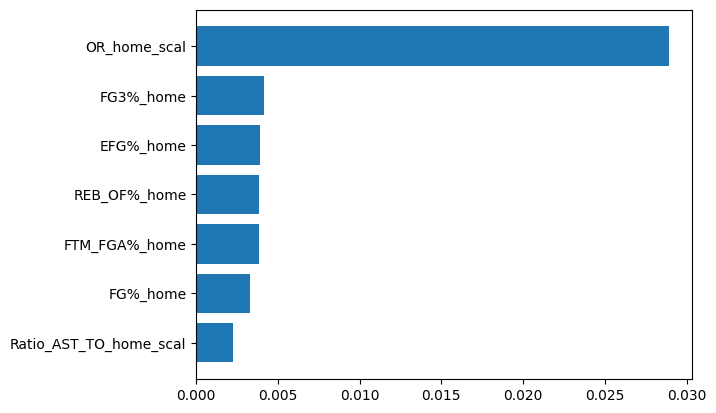

In [27]:
from sklearn.inspection import permutation_importance
results = permutation_importance(best_model, X_train, y_train, scoring='neg_mean_squared_error')
sorted_idx = results.importances_mean.argsort()
plt.barh(best_model.feature_names_in_[sorted_idx], results.importances_mean[sorted_idx])

## 5. Utiliza los Shapley values para entender la predicción de los dos primeros datos del conjunto de test. ¿Qué nos dicen? Compara las explicaciones para ambos datos. Pista: utiliza la sección “Explain a single prediction from the test set” del siguiente artículo de la documentación de la librería SHAP. Ten en cuenta que SHAP es un método bastante lento y tal vez debas reducir los datos que utilizas para entrenar el modelo.


Los valores de Shapley indican el impacto que cada característica tiene en la predicción del modelo para una observación específica. En los gráficos de cascada (waterfall plots), cada barra representa la contribución de una característica a la predicción final, partiendo del valor base.

Una de las propiedades fundamentales de los valores de Shapley es que siempre suman la diferencia entre la predicción y el valor de base sin tener en cuenta las variables del modelo es decir si valieran 0. Para los modelos de aprendizaje automático, esto significa que los valores SHAP de todas las características de entrada siempre sumarán la diferencia entre la salida del modelo base (esperada) y la salida actual del modelo para la predicción que se está explicando. La manera más fácil de ver esto es a través de un gráfico de cascada que comienza con nuestra expectativa previa del numero de puntos si no se cogieran rebotes, no hubiera asistencias, no se metieran triples.... y luego agrega características una por una hasta alcanzar la salida actual del modelo.

In [28]:
import shap
explainer = shap.KernelExplainer(best_model.predict, X_train)

# Get shap values for the test data observation whose index is 0, i.e. first observation in the test set
shap_values = explainer.shap_values(X_test.iloc[0,:])
expected_value = explainer.expected_value

#scalers['Points_home'].inverse_transform([shap_values])


Using 3800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [29]:
shap_values

array([-8.69065806e-04,  1.24108219e-03,  4.74188357e-03, -7.94013052e-05,
       -8.60639027e-03, -8.39458946e-02, -3.43754881e-03])

In [30]:
y_pred

array([0.35557027, 0.47695592, 0.80820168, 0.4028631 , 0.43593093,
       0.56825295, 0.28974717, 0.25554068, 0.60548326, 0.47320244,
       0.40358062, 0.76062229, 0.24212024, 0.29068904, 0.69694962,
       0.38848718, 0.37083173, 0.51995151, 0.46465615, 0.37331968,
       0.28595101, 0.61440856, 0.66142099, 0.31279926, 0.44406735,
       0.5769836 , 0.35830252, 0.74603191, 0.4075796 , 0.50942523,
       0.3669414 , 0.45659127, 0.28100987, 0.36217123, 0.52688364,
       0.41486974, 0.54535088, 0.24825669, 0.61339815, 0.35452605,
       0.26467811, 0.4647438 , 0.2736291 , 0.45819042, 0.75671773,
       0.59196984, 0.57131651, 0.38590697, 0.51807704, 0.58227185,
       0.39110925, 0.61378162, 0.24680317, 0.50506888, 0.36699441,
       0.52610304, 0.43455409, 0.22629786, 0.35351062, 0.52172656,
       0.55671838, 0.32570338, 0.34663018, 0.60453109, 0.30032364,
       0.54854758, 0.44295831, 0.34083449, 0.25690302, 0.26955966,
       0.51139649, 0.48158719, 0.49228682, 0.48025352, 0.32836

Vemos el gráfico de cascada para el primer jugador de los datos de test, vemos que son datos normalizados lo cual dificulta la interpretación a nivel baloncestistico. Pero si que podemos ver que en nuestro caso este  el número de rebotes reduce la prediccion del numero de puntos, lo mismo sucede pero mas ligeramente con el EFG, el % de Rebote ofensivo, el % de tiro de 3 y el ratio de asistencias por perdidas. Vemos que contribuyen positivamente, pero muy ligeramente tambien, el ratio de Tiros libres por tiro de campo y el porcentaje de tiro de campo

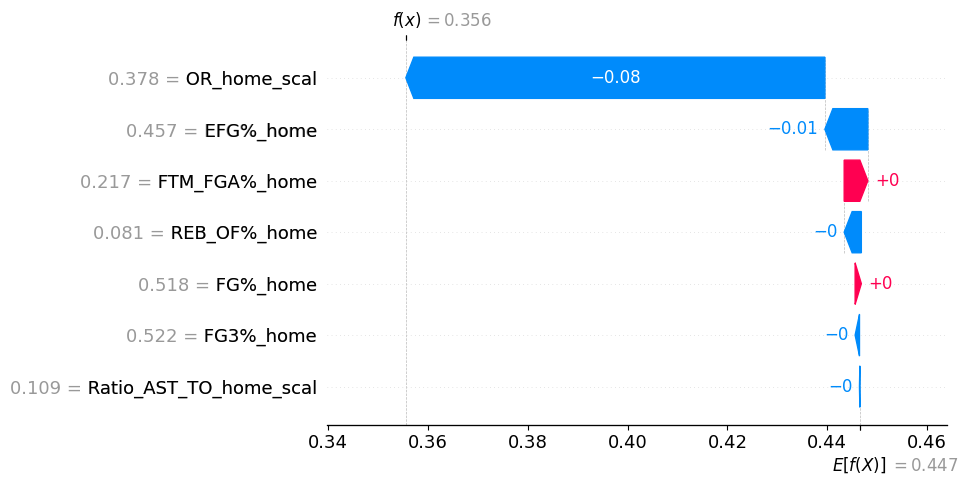

In [31]:
shap_explanation = shap.Explanation(values=shap_values, base_values=expected_value, data=X_test.iloc[0,:])

#shap_explanation = shap.Explanation(values=scalers['Points_home'].inverse_transform([shap_values])[0], base_values=scalers['Points_home'].inverse_transform([[expected_value]]), data=X_test.iloc[0,:])

# Generar el waterfall plot
shap.waterfall_plot(shap_explanation)



In [32]:
#scaler_output = scalers['Points_home']
#y_pred_original = scaler_output.inverse_transform(y_pred.reshape(-1, 1))
#y_test_original = scaler_output.inverse_transform(np.array(y_test).reshape(-1, 1))
#y_pred_original


Vamos  a hacer una transformacion de los shapley values para poder hacer una interpretación mas adecuada de estos desde el punto de vista del baloncesto y que puedan ayudar al entrenador

Using 3800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


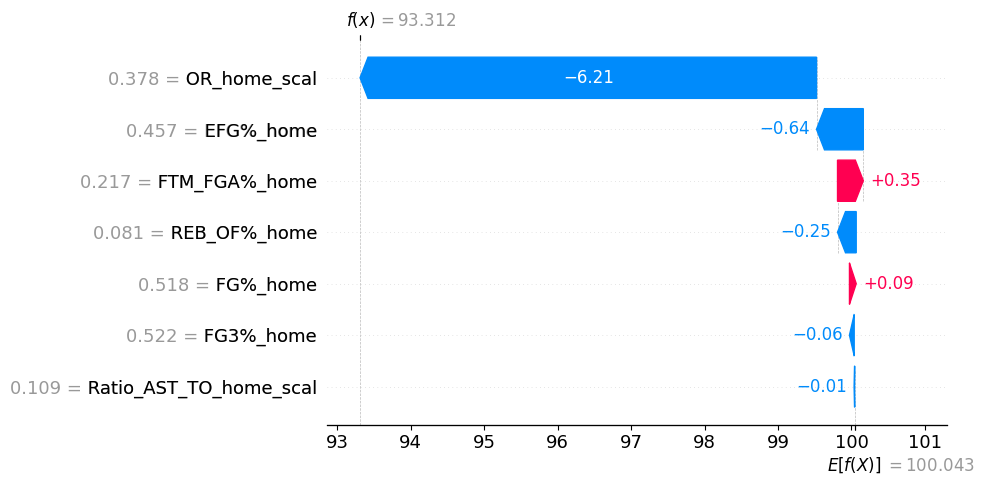

In [33]:
index_observacion = 0
# Obtener los valores SHAP para la primera observación en el conjunto de prueba
explainer = shap.KernelExplainer(best_model.predict, X_train)
shap_values_scaled = explainer.shap_values(X_test.iloc[index_observacion, :].values.reshape(1, -1))

# Asegurarnos de que shap_values_scaled sea un array 2D antes de invertir el escalado
shap_values_scaled_2d = np.array(shap_values_scaled).reshape(1, -1)

# Obtener la predicción escalada y desescalar
predicted_scaled = best_model.predict(X_test.iloc[index_observacion, :].values.reshape(1, -1)).reshape(-1, 1)
scaler_target = scalers['Points_home']
predicted_original = scaler_target.inverse_transform(predicted_scaled)[0][0]

# Invertir el escalado del valor esperado (expected_value)
expected_value_scaled = explainer.expected_value
expected_value_original = scaler_target.inverse_transform([[expected_value_scaled]])[0][0]

# Desescalar los valores SHAP directamente usando el mismo escalador
shap_values_original = scaler_target.inverse_transform(shap_values_scaled_2d + expected_value_scaled) - expected_value_original

# Generar la explicación SHAP para la primera observación
shap_explanation_single = shap.Explanation(
    values=shap_values_original[0], 
    base_values=expected_value_original, 
    data=X_test.iloc[index_observacion, :])

# Generar el waterfall plot
shap.waterfall_plot(shap_explanation_single)


Como vemos en el gráfico anterior partiendo de un valor base de 100 puntos, la prediccion de nuestro equipo para este partido era de 93.31 puntos y hemos visto que el numero de rebotes ofensivos ha contribuido negativamente en 6.21 puntos menos.

En el caso del segundo partido 

Using 3800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:11<00:00, 11.28s/it]


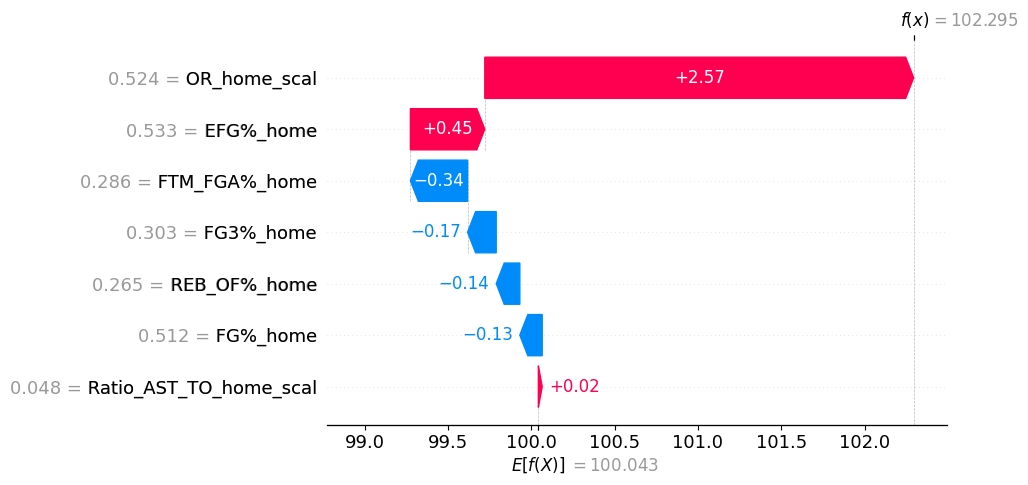

In [34]:
index_observacion = 1
# Obtener los valores SHAP para la primera observación en el conjunto de prueba
explainer = shap.KernelExplainer(best_model.predict, X_train)
shap_values_scaled = explainer.shap_values(X_test.iloc[index_observacion, :].values.reshape(1, -1))

# Asegurarnos de que shap_values_scaled sea un array 2D antes de invertir el escalado
shap_values_scaled_2d = np.array(shap_values_scaled).reshape(1, -1)

# Obtener la predicción escalada y desescalar
predicted_scaled = best_model.predict(X_test.iloc[index_observacion, :].values.reshape(1, -1)).reshape(-1, 1)
scaler_target = scalers['Points_home']
predicted_original = scaler_target.inverse_transform(predicted_scaled)[0][0]

# Invertir el escalado del valor esperado (expected_value)
expected_value_scaled = explainer.expected_value
expected_value_original = scaler_target.inverse_transform([[expected_value_scaled]])[0][0]

# Desescalar los valores SHAP directamente usando el mismo escalador
shap_values_original = scaler_target.inverse_transform(shap_values_scaled_2d + expected_value_scaled) - expected_value_original

# Generar la explicación SHAP para la primera observación
shap_explanation_single = shap.Explanation(
    values=shap_values_original[0], 
    base_values=expected_value_original, 
    data=X_test.iloc[index_observacion, :])

# Generar el waterfall plot
shap.waterfall_plot(shap_explanation_single)

En el caso del segundo partido, vemos que contribuyen positivamente en la predicción el numero de rebotes principalmente, y mas ligeramente el porcentaje de EFG y el ratio de asistencias/perdidas

## 6. Realiza lo mismo para una regresión logística (si has utilizado clasificación) o regresión lineal (si has utilizado regresión) de los factores de Oliver. Compara ambos métodos. ¿Dan explicaciones parecidas?


En el caso de mi estudio no predecimos el numero de victorias, ni la probabilidad de ganar un partido sino el numero de puntos, pero vamos a ver que capacidad tienen los factores de Oliver de predecir este outcome.

In [35]:
datosJugadores.columns

Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away', 'AWAY_TEAM_WINS', 'id_partido', 'FTM_FGA%_home',
       'FTM_FGA%_away', 'FG3%_home', 'FG3%_away', 'FG%_home', 'FG%_away',
       'FT%_home', 'FT%_away', 'Ratio_AST_TO_home', 'Ratio_AST_TO_away',
       'REB_OF%_home', 'REB_OF%_away', 'AST_home_scal', 'BLK_home_scal',
       'DREB_home_scal', 'FG3A_home_scal', 'FG3M_home_scal', 'FGA_home_scal',
       'FGM_home_scal', 'FTA_home_sca

In [36]:
variablesModeloOliver = ['EFG%_home', 'TOV%_home','REB_OF%_home','FTM_FGA%_home','EFG%_away', 'TOV%_away','REB_OF%_away','FTM_FGA%_away']
datosJugadoresModeloOliver = datosJugadores[variablesModeloOliver + [target_column]]
datosJugadoresModeloOliver

,EFG%_home,TOV%_home,REB_OF%_home,FTM_FGA%_home,EFG%_away,TOV%_away,REB_OF%_away,FTM_FGA%_away,Points_home_scal
1,0.530864,0.200131,0.297297,0.112360,0.480769,0.197935,0.314815,0.170213,0.486486
2,0.478022,0.108499,0.232558,0.127660,0.422222,0.109017,0.173913,0.284091,0.418919
3,0.561644,0.146699,0.139535,0.168539,0.537500,0.119344,0.317073,0.218391,0.513514
4,0.615385,0.112216,0.311475,0.166667,0.532468,0.127607,0.350000,0.131313,0.513514
5,0.487500,0.147025,0.227273,0.114943,0.552941,0.148630,0.191489,0.108696,0.378378
...,...,...,...,...,...,...,...,...,...
4995,0.560000,0.197276,0.333333,0.219512,0.448864,0.111524,0.200000,0.223529,0.459459
4996,0.525316,0.122888,0.226415,0.295455,0.605634,0.136268,0.361111,0.195402,0.364865
4997,0.440217,0.126411,0.142857,0.231707,0.456250,0.119623,0.186047,0.303797,0.297297
4998,0.500000,0.130536,0.162791,0.256410,0.321782,0.066974,0.078431,0.108434,0.472973


Seguimos la estrategia anterior de localizar una semilla y un tamaño de particion que optimice el modelo.

In [37]:
from sklearn.metrics import mean_squared_error
model = LinearRegression()

test_sizes = [0.15, 0.2, 0.25, 0.3]
random_states = [0, 1, 42, 43, 100, 313]

best_test_size = None
best_random_state = None
best_r2_score = -float('inf')

for test_size in test_sizes:
    for random_state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(datosJugadoresModeloOliver.drop('Points_home_scal', axis=1), datosJugadoresModeloOliver['Points_home_scal'], test_size=test_size, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        if r2 > best_r2_score:
            best_predictions = y_pred
            best_model = model
            best_r2_score = r2
            best_test_size = test_size
            best_random_state = random_state
            msr = mean_squared_error(y_test,y_pred)

print(f"Best test size: {best_test_size}")
print(f"Best random state: {best_random_state}")
print(f"Best R2 score: {best_r2_score}")
print(f"RMSE for this model: {msr}")



Best test size: 0.15
Best random state: 1
Best R2 score: 0.6426181419787411
RMSE for this model: 0.008143612987410703


In [38]:
best_model.coef_

array([ 1.77283875, -1.36728405,  0.003969  , -0.0184892 ,  0.08983153,
        0.20378698, -0.01446656, -0.00675247])

De momento vemos que el modelo no mejora los resultados anteriores. Obtenemos un $R^2$ inferior asi como un RMSE mayor. En este modelo observamos los coeficientes,estoss son excelentes para decirnos qué sucederá cuando cambiamos el valor de cada input, por sí solos no son una buena manera de medir la importancia general de un feature. Esto se debe a que el valor de cada coeficiente depende de la escala del feature de entrada. Por eso es mejor utilizar en el caso de modelos predictivos, los shapley values.


<BarContainer object of 8 artists>

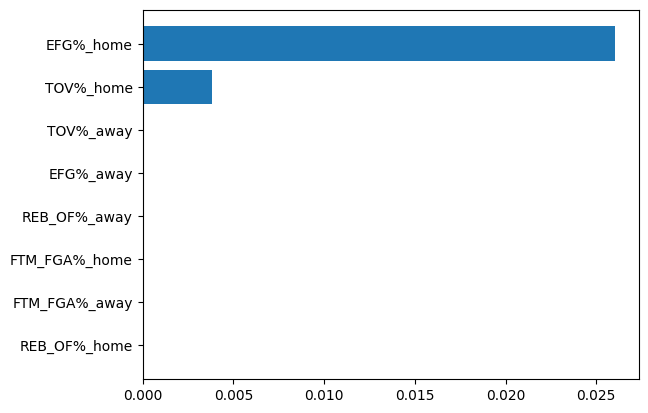

In [39]:
from sklearn.inspection import permutation_importance
results = permutation_importance(best_model, X_train, y_train, scoring='neg_mean_squared_error')
sorted_idx = results.importances_mean.argsort()
plt.barh(best_model.feature_names_in_[sorted_idx], results.importances_mean[sorted_idx])

Aunque habría que profundizar mas en estos resultados, como podemos imaginar el factor que mas influye en la puntuación de nuestro equipo  si planteamos un modelo en el que los features seleccionados son los factores de oliver vemos que no es del todo eficiente, ni en terminos de $R^2$ ni en terminos de ver un conjunto de features influyentes, ya que nos sale algo que no aporta información extra a lo que ya podriamos saber que es que en el numero de puntos influye la eficacia en el FG del equipo de nuestro equipo.

## 7. Reflexiona cómo puede ser útil toda la información que has obtenido a lo largo de la tarea para los entrenadores a la hora de preparar un partido.


Podemos identificar que puntos fuertes y debiles tiene nuestro equipo: Mediante el análisis de las características que tienen un mayor impacto en la predicción del número de puntos, los entrenadores pueden identificar las fortalezas y debilidades del equipo. Por ejemplo, si se observa que ciertos jugadores o estrategias tienen una influencia positiva significativa, se puede enfocar en optimizar esos aspectos.

Tambien puede ayudar en función de los factores que estan influyendo para anotar mas puntos, hacer una selección de jugadores mejor a partir de sus caracterisiticas individuales, o en el momento en que nosotros detectemos que necesitamos un determinado número de puntos podemos evaluar cuales de ellos van a ayudarnos mas en base a sus caracteristicas y a los features que son importantes en el número de puntos 

Tambien podemos evaluar que sistemas son los que mas influyen en mejorar las caracteristicas que tienen capacidad predictora en el número de puntos. Si hemos visto que es el número de rebotes ofensivos, tendremos que ver que sistemas o jugadas en conjunto con el roaster favorecen la posibilidad de capturar y aumentar el rebote ofensivo.



## 8. Reflexiona también sobre el proceso que has realizado hasta ahora, ¿puedes cambiar alguna decisión del punto 2. que mejore la precisión del modelo o que hubiese dado información más útil al entrenador? Extra: Si tienes tiempo, cambia algunas decisiones y repite el ejercicio. Comentario: ¡Recuerda que el proceso de análisis de datos es un proceso iterativo!


Una vez vistas las variables y analizando el problema. Vamos a probar a aumentar el numero de inputs en el modelo incluyendo algunas variables del equipo rival para ver si tambien no están influyendo en el número de puntos que anotamos. Vamos a incluir el número de posesiones, que no habiamos tenido en cuenta, las faltas personales que hace el otro equipo, el True Shooting Percentage, el número de rebotes defensivo

- Porcentaje de tiros de campos propio
- Porcentaje de tiros de 3 propio
- Ratio Tiros libres por tiros de campo propio
- Ratio de Asistencias / Perdidas propio
- EFG% propio
- Offensive Rating
- Tasa de Rebotes Ofensivos Propio
- Numero de Possesiones propio
- True Shooting Percentage Propio
- Numero de Rebotes defensivo
- Faltas Personales del otro equipo
- Perdidas del otro equiop



In [40]:
datosJugadores.columns

Index(['Unnamed: 0', 'GAME_DATE_EST', 'AST_home', 'BLK_home', 'DREB_home',
       'FG3A_home', 'FG3M_home', 'FGA_home', 'FGM_home', 'FTA_home',
       'FTM_home', 'OREB_home', 'PF_home', 'STL_home', 'TO_home', 'AST_away',
       'BLK_away', 'DREB_away', 'FG3A_away', 'FG3M_away', 'FGA_away',
       'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'STL_away',
       'TO_away', 'HOME_TEAM_WINS', 'Points_home', 'Points_away',
       'Possesions_home', 'Possesions_away', 'EFG%_home', 'EFG%_away',
       'TS%_home', 'TS%_away', 'TOV%_home', 'TOV%_away', 'OR_home', 'OR_away',
       'DR_home', 'DR_away', 'AWAY_TEAM_WINS', 'id_partido', 'FTM_FGA%_home',
       'FTM_FGA%_away', 'FG3%_home', 'FG3%_away', 'FG%_home', 'FG%_away',
       'FT%_home', 'FT%_away', 'Ratio_AST_TO_home', 'Ratio_AST_TO_away',
       'REB_OF%_home', 'REB_OF%_away', 'AST_home_scal', 'BLK_home_scal',
       'DREB_home_scal', 'FG3A_home_scal', 'FG3M_home_scal', 'FGA_home_scal',
       'FGM_home_scal', 'FTA_home_sca

In [41]:
variablesModeloAvanzado = ['FG3%_home', 'FG%_home', 'FTM_FGA%_home', 'Ratio_AST_TO_home','EFG%_home', 'OR_home_scal','OREB_home_scal','Possesions_home_scal','TS%_home','DREB_home_scal','PF_away_scal','TO_away_scal']

datosJugadoresModelAvanzado = datosJugadores_backup[variablesModeloAvanzado + [target_column]]
datosJugadoresModelAvanzado

,FG3%_home,FG%_home,FTM_FGA%_home,Ratio_AST_TO_home,EFG%_home,OR_home_scal,OREB_home_scal,Possesions_home_scal,TS%_home,DREB_home_scal,PF_away_scal,TO_away_scal,Points_home_scal
1,0.545455,0.539326,0.112360,2.000000,0.530864,0.392513,0.40,0.510428,0.560239,0.552632,0.300000,0.285714,0.486486
2,0.500000,0.542553,0.127660,3.900000,0.478022,0.468571,0.36,0.315954,0.496957,0.578947,0.233333,0.357143,0.418919
3,0.369565,0.460674,0.168539,4.800000,0.561644,0.556928,0.20,0.329510,0.601719,0.315789,0.400000,0.357143,0.513514
4,0.319149,0.382353,0.166667,2.700000,0.615385,0.606816,0.72,0.262252,0.603275,0.263158,0.433333,0.464286,0.513514
5,0.348837,0.459770,0.114943,2.133333,0.487500,0.394911,0.36,0.341502,0.511716,0.578947,0.333333,0.392857,0.378378
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.384615,0.500000,0.219512,1.642857,0.560000,0.479514,0.48,0.396246,0.590989,0.526316,0.500000,0.357143,0.459459
4996,0.269231,0.363636,0.295455,1.692308,0.525316,0.526906,0.44,0.191867,0.548745,0.184211,0.500000,0.642857,0.364865
4997,0.375000,0.426829,0.231707,3.285714,0.440217,0.272916,0.20,0.423358,0.459948,0.500000,0.466667,0.357143,0.297297
4998,0.307692,0.512821,0.256410,1.928571,0.500000,0.497038,0.24,0.350365,0.546917,0.815789,0.566667,0.357143,0.472973


In [42]:
X_train, X_test, y_train, y_test = train_test_split(datosJugadoresModelAvanzado.drop('Points_home_scal', axis=1), datosJugadoresModelAvanzado['Points_home_scal'], test_size=0.2, random_state=0)

KNNmodel = KNeighborsRegressor()

param_grid = {
    'n_neighbors': range(3,11,2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(estimator=KNNmodel, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

best_r2_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f"Best R2 score: {best_r2_score}")
print(f"Best hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print(f"R2 score on test set: {test_r2}")
msr = mean_squared_error(y_test,y_pred)
print(f"RMSE for this model: {msr}")


Best R2 score: 0.8358721963293965
Best hyperparameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
R2 score on test set: 0.8494186277583318
RMSE for this model: 0.003494941580967316


<BarContainer object of 12 artists>

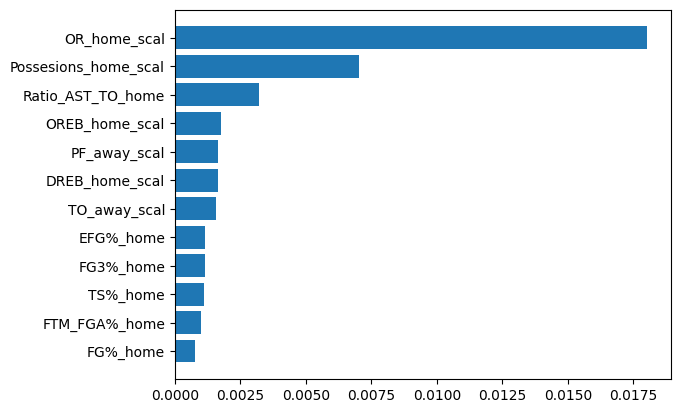

In [43]:
from sklearn.inspection import permutation_importance
results = permutation_importance(best_model, X_train, y_train, scoring='neg_mean_squared_error')
sorted_idx = results.importances_mean.argsort()
plt.barh(best_model.feature_names_in_[sorted_idx], results.importances_mean[sorted_idx])

Hemos visto que incluyendo mas variables hemos mejorado el modelo, sobre todo porque el número de posesiones es una variable que esta influenciando en el número de puntos como era de esperar,  es decir que nuestro objetivo para maximizar los puntos va a ser buscar estrategias que: 

- Maximicen el número de rebotes ofensivos
- Reduzcan el tiempo de ataque para poder conseguir el mayor numero de posesiones posibles.